출처: https://neurowhai.tistory.com/273 [NeuroWhAI의 잡블로그]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from PIL import Image
path = "/content/drive/MyDrive/Colab Notebooks/2021_data_project_swcon/게임에셋 도전!/"
images = os.listdir(path + "pokemon")

for i, name in enumerate(images):
    png = Image.open(path + "pokemon/" + name)
    png.load()

    background = Image.new("RGB", png.size, (0,0,0))
    background.paste(png, mask=png.split()[3]) #3은 alpha channel

    background.thumbnail((32,32), Image.ANTIALIAS)
    background.save(path + "pokemon_rgb/" + str(i) + ".jpg", 'JPEG', quality=80)

(819, 32, 32, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch: 0, D Loss: 0.6704522185027599, AM Loss: 0.533054067127523


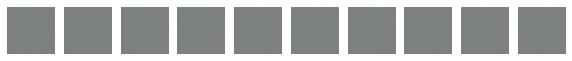

Epoch: 20, D Loss: 0.3664004299789667, AM Loss: 2.5652893856167793


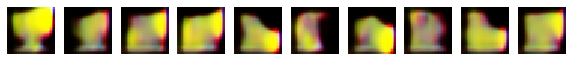

Epoch: 40, D Loss: 0.36051076278090477, AM Loss: 2.683026447892189


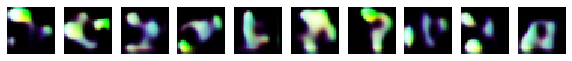

Epoch: 60, D Loss: 0.7373673729598522, AM Loss: 1.3881799057126045


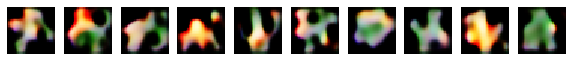

Epoch: 80, D Loss: 0.47901029884815216, AM Loss: 1.8751929178833961


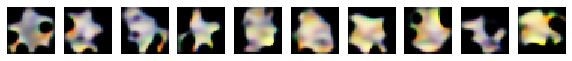

Epoch: 100, D Loss: 0.4737548790872097, AM Loss: 1.830638613551855


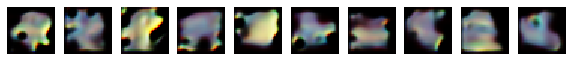

Epoch: 120, D Loss: 0.42481010034680367, AM Loss: 2.2180151492357254


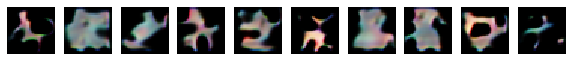

In [ ]:
import os.path
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import keras.backend as K
import matplotlib.pyplot as plt
import os
from PIL import Image
path = "/content/drive/MyDrive/Colab Notebooks/2021_data_project_swcon/게임에셋 도전!/"
K.set_image_data_format('channels_last')

class Gan:
    def __init__(self, img_data):
        img_size = img_data.shape[1]
        channel = img_data.shape[3] if len(img_data.shape) >= 4 else 1

        self.img_data = img_data 
        self.input_shape = (img_size, img_size, channel)

        self.img_rows = img_size
        self.img_cols = img_size
        self.channel = channel
        self.noise_size = 100

        self.create_d()
        self.create_g()

        optimizer = Adam(lr=0.0004) 
        self.D.trainable = False 
        self.AM = Sequential() 
        self.AM.add(self.G) 
        self.AM.add(self.D) 
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer)

    def create_d(self):
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=self.input_shape, padding='same')) 
        self.D.add(LeakyReLU(alpha=0.2)) 
        self.D.add(Dropout(dropout)) 
        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2)) 
        self.D.add(Dropout(dropout)) 
        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same')) 
        self.D.add(LeakyReLU(alpha=0.2)) 
        self.D.add(Dropout(dropout)) 
        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same')) 
        self.D.add(LeakyReLU(alpha=0.2)) 
        self.D.add(Dropout(dropout)) 
        self.D.add(Flatten()) 
        self.D.add(Dense(1)) 
        self.D.add(Activation('sigmoid')) 
        self.D.summary() 
        return self.D
    
    def create_g(self):
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 8
        self.G.add(Dense(dim*dim*depth, input_dim=self.noise_size))
        self.G.add(BatchNormalization(momentum=0.9)) 
        self.G.add(Activation('relu')) 
        self.G.add(Reshape((dim, dim, depth))) 
        self.G.add(Dropout(dropout)) 
        self.G.add(UpSampling2D()) 
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same')) 
        self.G.add(BatchNormalization(momentum=0.9)) 
        self.G.add(Activation('relu')) 
        self.G.add(UpSampling2D()) 
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same')) 
        self.G.add(BatchNormalization(momentum=0.9)) 
        self.G.add(Activation('relu')) 
        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9)) 
        self.G.add(Activation('relu')) 
        self.G.add(Conv2DTranspose(self.channel, 5, padding='same'))
        self.G.add(Activation('sigmoid')) 
        self.G.summary() 
        return self.G

    def train(self, batch_size = 100):
        images_train = self.img_data[np.random.randint(0, self.img_data.shape[0], size =batch_size), :, :, :]

        noise = np.random.uniform(-1.0, 1.0, size = [batch_size, self.noise_size])
        images_fake = self.G.predict(noise)

        # Train D
        x = np.concatenate((images_train, images_fake))
        y = np.ones([2*batch_size, 1])
        y[batch_size:, :] = 0
        self.D.trainable = True
        self.D.compile(optimizer= Adam(lr=0.0004), loss='binary_crossentropy')
        d_loss = self.D.train_on_batch(x,y)

        #train G
        y = np.ones([batch_size,1])
        noise = np.random.uniform(-1.0, 1.0, size = [batch_size, self.noise_size])
        self.D.trainable = False
        a_loss = self.AM.train_on_batch(noise,y)

        return d_loss, a_loss, images_fake

    def save(self):
        self.G.save_weights('gan_g_weights.h5')
        self.D.save_weights('gan_d_weights.h5')
    def load(self):
        if os.path.isfile('gan_g_weights.h5'):
            self.G.load_weights('gan_g_weigths.h5')
            print("Load G from file")
        if os.path.isfile('gan_d_weights.h5'):
            self.D.load_weights('gan_d_weigths.h5')
            print("Load D from file")

class PokemonData():
    def __init__(self):
        img_data_list = []
        images = os.listdir("/content/drive/MyDrive/Colab Notebooks/2021_data_project_swcon/게임에셋 도전!/pokemon_rgb")

        for path in images:
            img = Image.open("/content/drive/MyDrive/Colab Notebooks/2021_data_project_swcon/게임에셋 도전!/pokemon_rgb/" + path)
            img_data_list.append([np.array(img).astype('float32')])
        
        self.x_train = np.vstack(img_data_list) / 255.0
        print(self.x_train.shape)
    
dataset = PokemonData()
x_train = dataset.x_train

gan = Gan(x_train)


epochs = 500
sample_size = 10
batch_size = 100
train_per_epoch = x_train.shape[0] // batch_size

for epoch in range(0, epochs):
    total_d_loss = 0.0
    total_a_loss = 0.0
    imgs = None

    for batch in range(0, train_per_epoch):
        d_loss, a_loss, t_imgs = gan.train(batch_size)
        total_d_loss += d_loss
        total_a_loss += a_loss
        if imgs is None:
            imgs = t_imgs
    
    if epoch % 20 == 0 or epoch == epochs - 1 :
        total_d_loss /= train_per_epoch
        total_a_loss /= train_per_epoch
        print("Epoch: {}, D Loss: {}, AM Loss: {}".format(epoch, total_d_loss, total_a_loss))

        #Show images
        fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1))
        for i in range(0, sample_size):
            ax[i].set_axis_off()
            ax[i].imshow(imgs[i].reshape((gan.img_rows, gan.img_cols, gan.channel)), interpolation='nearest')
        plt.show()
        plt.close(fig)

        gan.save()
         

